<a href="https://colab.research.google.com/github/nityamshah/datascience/blob/main/NityShahU3proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
  #installations and libraries neccesary to run the code
  !pip install preliz
  import preliz as pz
  import numpy as np
  import matplotlib.pyplot as plt
  import pandas as pd
  import arviz as az
  import pymc as pm

In this project, I'm creating a model for Katie Ledecky's 1500 LCM. This data is taken from her major meets from the age of 17 to 27. Before this, data is less realistic because she was young. The times below are converted from minutes to seconds. For reference, 15 minutes is 900 seconds.

In [ ]:
times = [
    930.02,
    937.35,
    938.25,
    939.73,
    947.43,
    926.27,
    929.64,
    938.81,
    941.22,
    946.38,
    930.15,
    937.99,
    938.99,
    944.13,
    947.02,
    935.35,
    937.34,
    939.45,
    940.50,
    940.55,
    940.63,
    943.10,
    945.32,
    942.92,
    929.51,
    935.98,
    948.90,
    920.48,
    938.97,
    945.59,
    931.82,
    935.65,
    947.54,
    925.48,
    927.71,
    942.23,
    928.36,
    934.23
]

Here, I'm visualizing the data with a 10 bin histogram.

(array([1., 1., 3., 5., 1., 5., 7., 7., 3., 5.]),
 array([920.48 , 923.322, 926.164, 929.006, 931.848, 934.69 , 937.532,
        940.374, 943.216, 946.058, 948.9  ]),
 <BarContainer object of 10 artists>)

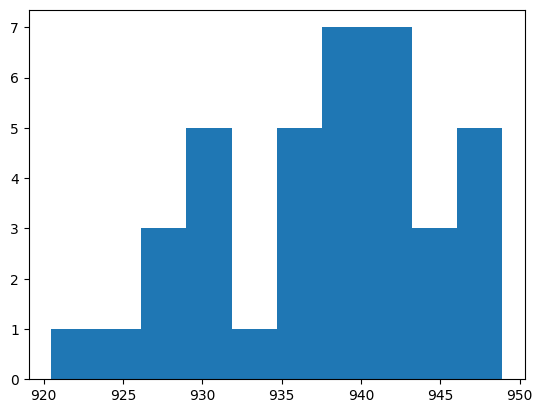

In [ ]:
plt.hist(times)

In general, it appears to range from around 920 to 950, centered around 40. It is slightly skewed left but also has an abnormal dip in the middle.

I begun with a uniform prior for the mean and half normal prior for the standard deviation. I used half normal for the standard deviation because it's going to be all positive values that land more heavily on smaller values. I modeled my first liklihood with just a normal model to see how it looked. Given the histogram, it probably was not going to be a good fit.

In [ ]:
with pm.Model() as model_swim:
    # normal distribution for the mean
    μ = pm.Uniform('μ', lower=920, upper=950)

    #half normal distribution for standard deviation because the standard deviation is all positive and heavier near lower values
    σ = pm.HalfNormal('σ', sigma=5)

    #likelihood
    Y = pm.Normal('Y', mu = μ, sigma = σ, observed=times)
    idata = pm.sample()

Output()

Output()

Output()

<Axes: xlabel='Y'>

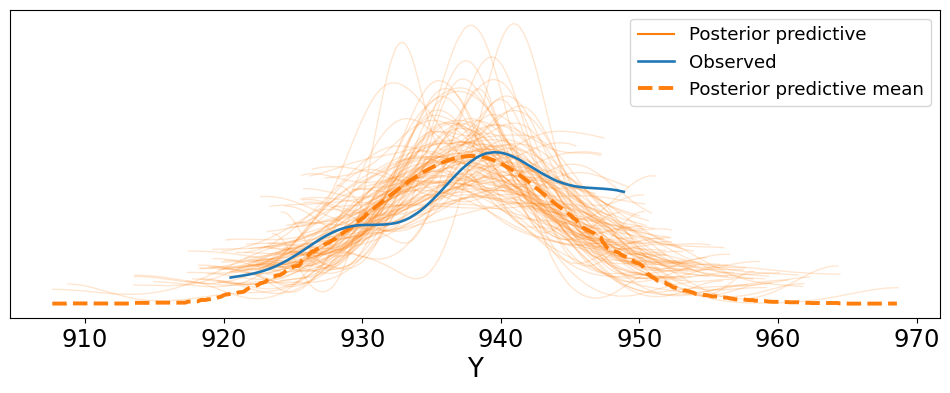

In [ ]:
pm.sample_posterior_predictive(idata, model=model_swim, extend_inferencedata=True)
az.plot_ppc(idata, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

This clearly wasn't a great fit, but before I moved on, I wanted to make the prior for the mean a normal prior in case it made a difference. The normal prior ended up looking pretty similar to the uniform as shown below.

Confidence wise, this model is also not that confident because the thin orange lines are very scattered from the dashed orange line. The guesses weren't consistently close to the mean.

In [ ]:
with pm.Model() as model_swim:
    # normal distribution for the mean
    μ = pm.Normal('μ', mu=940, sigma=5)

    #half normal distribution for standard deviation because the standard deviation is all positive and heavier near lower values
    σ = pm.HalfNormal('σ', sigma=5)

    #likelihood
    Y = pm.Normal('Y', mu = μ, sigma = σ, observed=times)
    idata = pm.sample()

Output()

Output()

Output()

<Axes: xlabel='Y'>

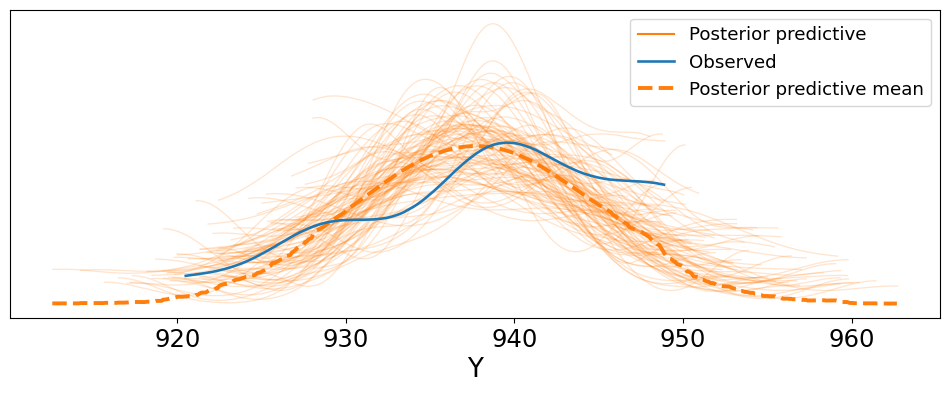

In [ ]:
pm.sample_posterior_predictive(idata, model=model_swim, extend_inferencedata=True)
az.plot_ppc(idata, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

As we saw in the histogram and on these graphs, the observed data is clearly skewed slightly negatively, so I wanted to add a skew into the model. I tried this with skew normal and got some divergences but then realized that skew student T is better for more outliers in the negative direction (student T distributions are better for outliers in general or distributions with heavier tails). I made the a < b so that it is skewed negatively.

This makes sense because not all of her times are going to be her fastest but there will be a couple of pretty low values while the majority of them are centered around some middle value - in this case around 940.

I kept the μ and σ priors the same as before.

This model is still not confident.

In [ ]:
#ST is for skew T
with pm.Model() as model_swimST:
    #normal distribution for the mean
    μ = pm.Normal('μ', mu=940, sigma=5)

    #half normal distribution for standard deviation because the standard deviation is all positive and heavier near lower values
    σ = pm.HalfNormal('σ', sigma=5)

    #when a is larger than b, the dist. is positively skewed, when a is less its negative
    a = pm.HalfNormal('a', sigma=1)
    b = pm.HalfNormal('b', sigma=5)

    #SkewStudentT liklihood
    y = pm.SkewStudentT('y',mu=μ, sigma=σ, a = a, b = b, observed=times)
    idataST = pm.sample()

Output()

Output()

Output()

(910.0, 970.0)

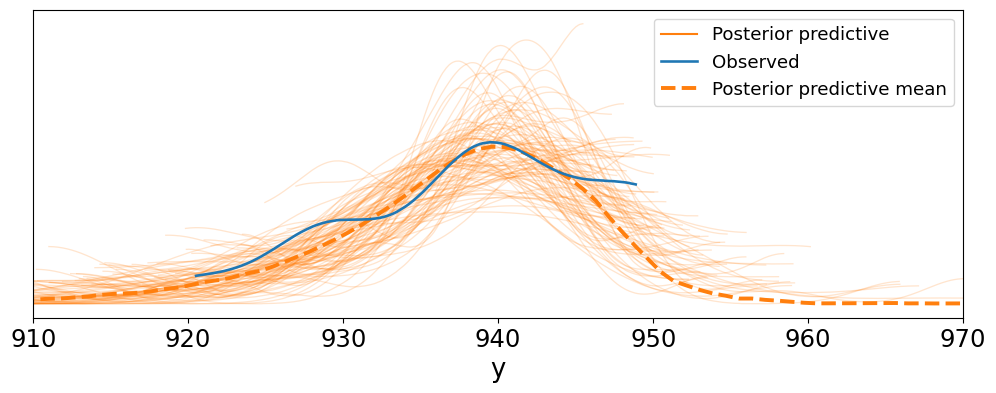

In [ ]:
pm.sample_posterior_predictive(idataST, model=model_swimST, extend_inferencedata=True)
ax = az.plot_ppc(idataST, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])
ax.set_xlim(910, 970) #limiting the frame so it's easier to see

This ended up being a pretty good fit, but I modified the skew sigma values to increase the skew a little.

This model shows much more confidence than the first two. The thin orange lines are closer to the dashed line and less all over the place.

In [ ]:
#ST is for skew T
with pm.Model() as model_swimST:
     # normal distribution for the mean
    μ = pm.Normal('μ', mu=940, sigma=5)

    #half normal distribution for standard deviation because the standard deviation is all positive and heavier near lower values
    σ = pm.HalfNormal('σ', sigma=5)

    #when a is larger than b, the dist. is positively skewed, when a is less its negative
    a = pm.HalfNormal('a', sigma=1)
    b = pm.HalfNormal('b', sigma=8)

    #SkewStudentR, which is the same as a T, except with more unusually high
    #or unusually low values.
    y = pm.SkewStudentT('y',mu=μ, sigma=σ, a = a, b = b, observed=times)
    idataST = pm.sample()

Output()

Output()

Output()

(910.0, 970.0)

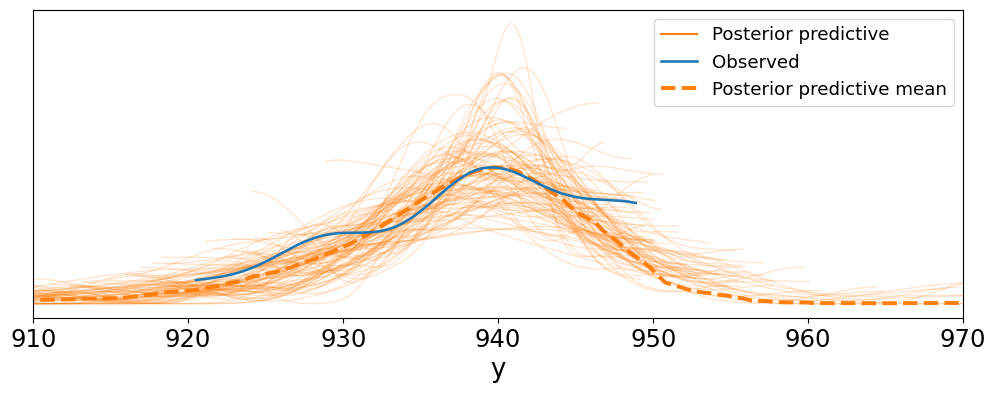

In [ ]:
pm.sample_posterior_predictive(idataST, model=model_swimST, extend_inferencedata=True)
ax = az.plot_ppc(idataST, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])
ax.set_xlim(910, 970)

The tail on the right comes from the way the swimming data is, but with the models we have this is probably the best it will get. It's also the most confident of the models.